<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/ML_AI24_HT7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


# **Базовое решение и пример формирования файла под submission**


In [4]:
# !wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
# !wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

In [7]:
from catboost import CatBoostClassifier
import pandas as pd
from tqdm import tqdm

train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
sample_submission = pd.read_csv('sample_submission.csv')

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [8]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

In [9]:
object_cols = []
for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
      object_cols.append(idx)

431it [00:00, 95627.65it/s]


In [10]:
X_train = df_train.drop('isFraud', axis=1)
X_train = X_train.fillna('')
y_train = df_train['isFraud'].values

cb = CatBoostClassifier(iterations=3)
cb.fit(X_train, y_train, object_cols, )

Learning rate set to 0.5
0:	learn: 0.2082395	total: 369ms	remaining: 739ms
1:	learn: 0.1360790	total: 672ms	remaining: 336ms
2:	learn: 0.1180984	total: 1s	remaining: 0us


In [11]:
predictions = cb.predict_proba(df_test.fillna(''))

In [12]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
sub.head()

,TransactionID,isFraud
0,3404559,0.978714
1,3404560,0.935724
2,3404561,0.946864
3,3404562,0.978714
4,3404563,0.970637


In [13]:
# Сохранение submission
sub.to_csv('submission_baseline.csv', index=False)

### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

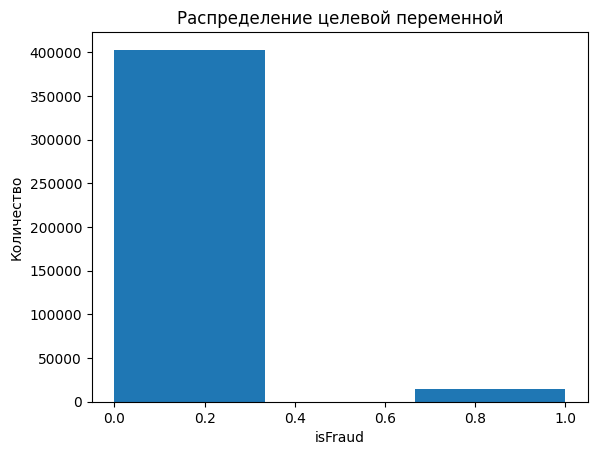

In [9]:
import matplotlib.pyplot as plt

# Анализ целевой переменной
plt.hist(df_train['isFraud'], bins=3)
plt.title('Распределение целевой переменной')
plt.xlabel('isFraud')
plt.ylabel('Количество')
plt.show()
# Большая часть данных не fraud

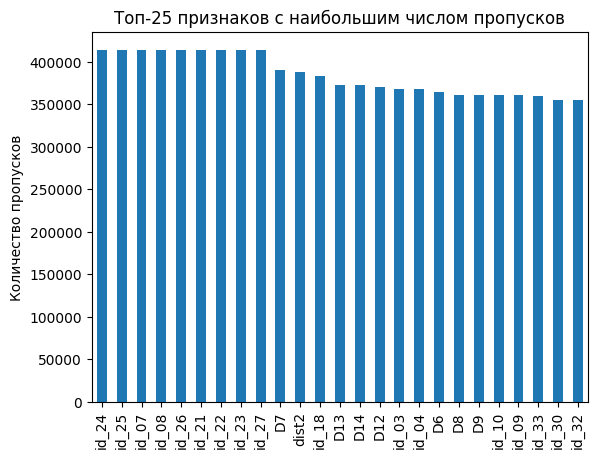

In [10]:
# Анализ пропусков
missing_values = df_train.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

top_n = 25
missing_values = missing_values[:top_n]

missing_values.plot(kind='bar')
plt.title(f'Топ-{top_n} признаков с наибольшим числом пропусков')
plt.ylabel('Количество пропусков')
plt.xticks(rotation=90)

plt.show()
# немало признаков где пропуски почти все данные датасета

In [11]:
# Признаки id_24, id_25 хоть и пустые - но не полность. Там есть значения - оставляем, поскольку кетбуст умеет работать с пропусками
print('Всего строк:', len(df_train))
print(df_train.isnull().sum().sort_values(ascending=False).head(2))

Всего строк: 417559
id_24    413935
id_25    413629
dtype: int64


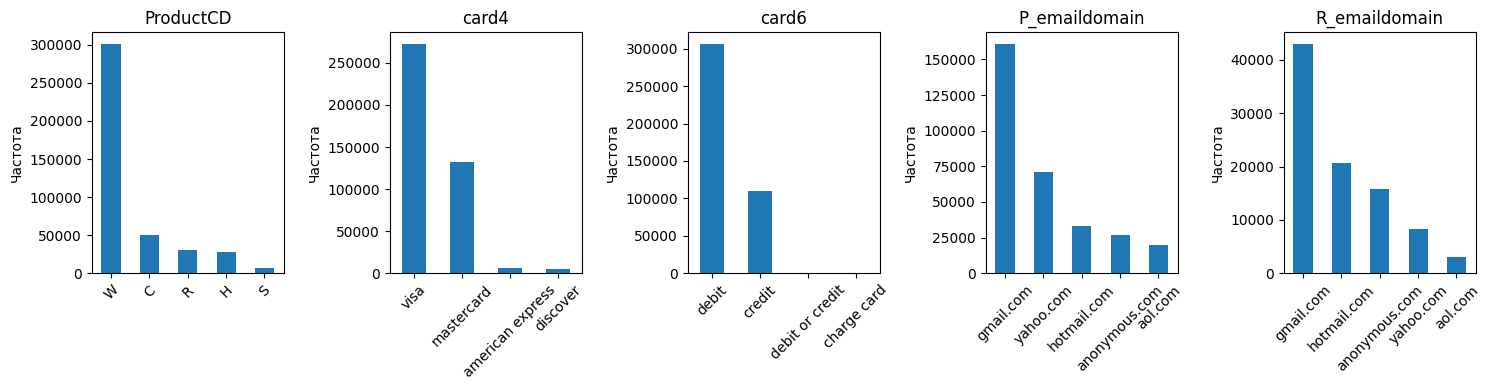

In [12]:
# Анализ категориальных признаков (частично)
object_cols = [col for col in df_train.columns if df_train[col].dtype == 'O']

top_n_cols = 5 
selected_cols = object_cols[:top_n_cols]

plt.figure(figsize=(15, 4))

for i, col in enumerate(selected_cols, 1):
    plt.subplot(1, top_n_cols, i)
    df_train[col].value_counts().nlargest(5).plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()
# лучше понял данные, далее их буду приводить к ок виду

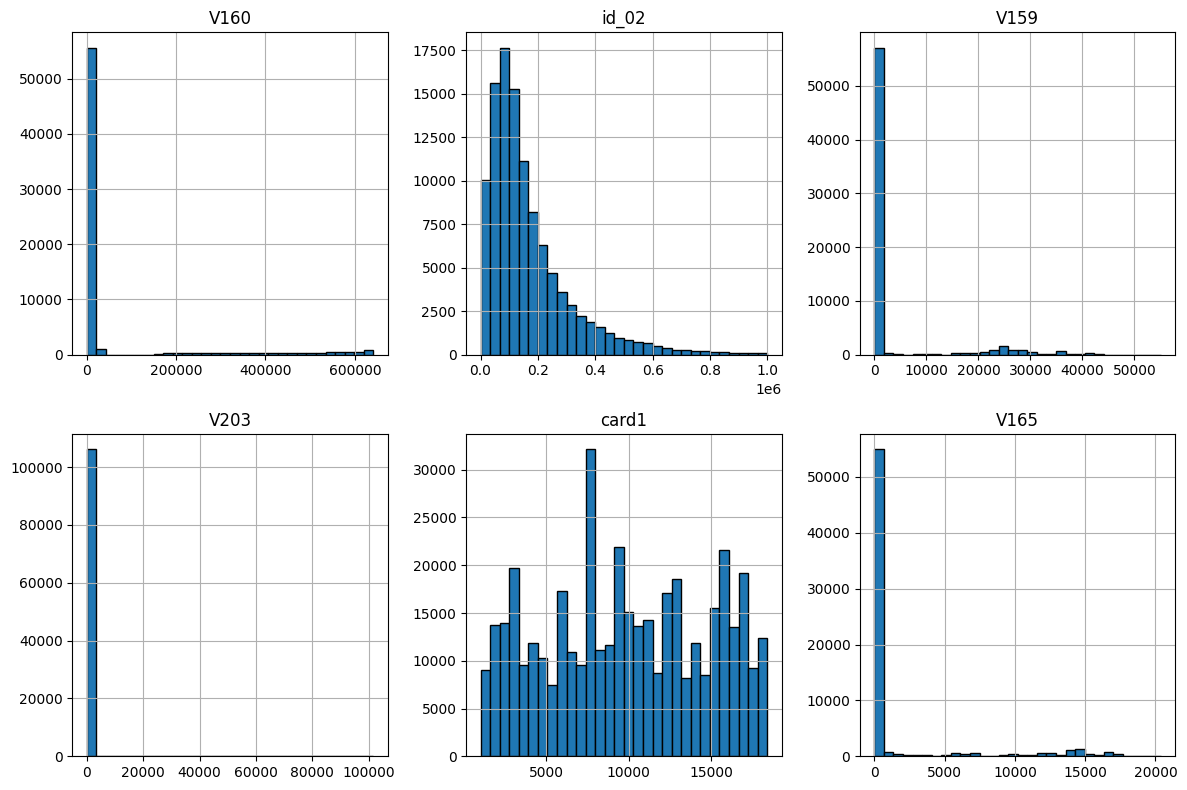

In [13]:
# Анализ 6 самых больших числовых признаков
num_cols = df_train.select_dtypes(include=['number']).columns.drop('isFraud')
top_num_cols = df_train[num_cols].var().nlargest(6).index
plt.figure(figsize=(12, 8))

for i, col in enumerate(top_num_cols, 1):
    plt.subplot(2, 3, i)
    df_train[col].hist(bins=30, edgecolor='black')
    plt.title(col)

plt.tight_layout()
plt.show()

# лучше понял данные, далее их буду приводить к ок виду

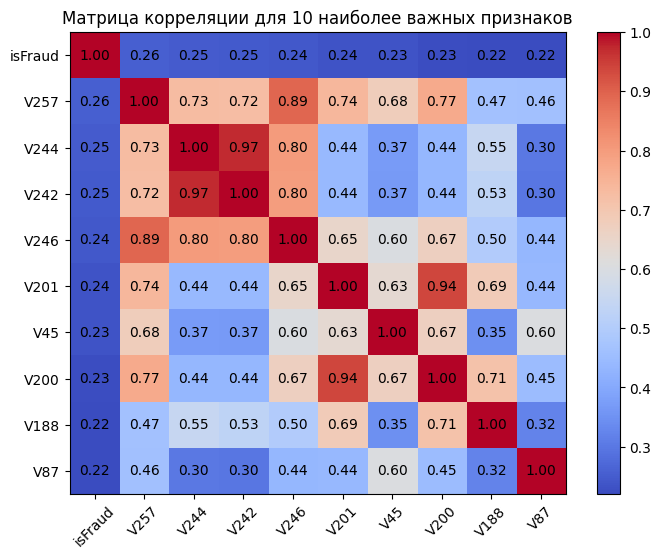

In [14]:
import matplotlib.pyplot as plt
import numpy as np

num_cols = df_train.select_dtypes(include=['number']).columns
df_temp = df_train[num_cols].fillna(df_train[num_cols].mean())
df_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
df_temp = df_temp.loc[:, df_temp.var() != 0]

top_10_features = df_temp.corrwith(df_train['isFraud']).sort_values(ascending=False).head(10).index
corr_matrix = df_temp[top_10_features].corr()

plt.figure(figsize=(8, 6))
cax = plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Матрица корреляции для 10 наиболее важных признаков')
plt.xticks(range(len(top_10_features)), top_10_features, rotation=45)
plt.yticks(range(len(top_10_features)), top_10_features)

for i in range(len(top_10_features)):
    for j in range(len(top_10_features)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.show()
# узнали высокие корелляции признаков

In [15]:
duplicates = df_train.duplicated().sum()
df_train = df_train.drop_duplicates()
print(f'Количество удалённых дубликатов: {duplicates}')

Количество удалённых дубликатов: 270


In [14]:
# Windows 10 to Windows
df_train['id_30'] = df_train['id_30'].str.split().str[0]
df_test['id_30'] = df_test['id_30'].str.split().str[0]

In [16]:
# chrome 62.0 to chrome
df_train['id_31'] = df_train['id_31'].str.split().str[0]
df_test['id_31'] = df_test['id_31'].str.split().str[0]

In [17]:
# match_status:2 to 2
df_train['id_34'] = df_train['id_34'].str.split(':').str[-1].astype(float)
df_test['id_34'] = df_test['id_34'].str.split(':').str[-1].astype(float)


# IP_PROXY:ANONYMOUS to ANONYMOUS
df_train['id_23'] = df_train['id_23'].str.split(':').str[-1]
df_test['id_23'] = df_test['id_23'].str.split(':').str[-1]

In [19]:
cols_to_process = ['id_35', 'id_36', 'id_37', 'id_38']
for col in cols_to_process:
    df_train[col] = df_train[col].replace({'T': 1, 'F': 0})
    df_train[col] = df_train[col].astype(float)

    df_test[col] = df_test[col].replace({'T': 1, 'F': 0})
    df_test[col] = df_test[col].astype(float)

In [21]:
cols_to_process = ['id_29', 'id_27', 'id_16', 'id_12']
for col in cols_to_process:
    df_train[col] = df_train[col].replace({'Found': 1, 'NotFound': 0})
    df_train[col] = df_train[col].astype(float)

    df_test[col] = df_test[col].replace({'Found': 1, 'NotFound': 0})
    df_test[col] = df_test[col].astype(float)

In [23]:
df_train['id_28'] = df_train['id_28'].replace({'Found': 1, 'New': 0})
df_train['id_28'] = df_train[col].astype(float)

df_test['id_28'] = df_test['id_28'].replace({'Found': 1, 'New': 0})
df_test['id_28'] = df_test['id_28'].astype(float)

In [25]:
import numpy as np

df_train['id_15'] = df_train['id_15'].replace({'Found': 1, 'New': 0, 'Unknown': np.nan})
df_train['id_15'] = df_train['id_15'].astype(float)

df_test['id_15'] = df_test['id_15'].replace({'Found': 1, 'New': 0, 'Unknown': np.nan})
df_test['id_15'] = df_test['id_15'].astype(float)

In [26]:
object_cols = [col for col in df_train.columns if df_train[col].dtype == 'O']

for col in object_cols:
    df_train[col] = df_train[col].fillna('').astype('category')
    df_test[col] = df_test[col].fillna('').astype('category')

In [27]:
X = df_train.drop(columns=['isFraud'])
y = df_train['isFraud']

In [28]:
object_cols = [col for col in df_train.columns if df_train[col].dtype == 'category']

# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

In [48]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import lightgbm as lgb
import numpy as np

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def evaluate_model(model, X, y, kf):
    cv_scores = []
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)[:, 1]
        cv_scores.append(roc_auc_score(y_val, preds))
    return np.mean(cv_scores)

catboost_params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'cat_features': [X.columns.get_loc(col) for col in object_cols],
    'verbose': False
}

lightgbm_params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 40,
    'learning_rate': 0.1,
    'n_estimators': 250,
    'subsample': 0.5,
    'colsample_bytree': 0.75,
    'verbose': -1
}

# CatBoost
catboost_model = CatBoostClassifier(**catboost_params)
catboost_cv_score = evaluate_model(catboost_model, X, y, kf)

# LightGBM
lightgbm_model = lgb.LGBMClassifier(**lightgbm_params)
lightgbm_cv_score = evaluate_model(lightgbm_model, X, y, kf)

# Обучение CatBoost
catboost_model.fit(X, y)
catboost_preds = catboost_model.predict_proba(df_test)[:, 1]
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': catboost_preds})
sub.to_csv('catboost_preds.csv', index=False)

# Обучение LightGBM
lightgbm_model.fit(X, y)
lightgbm_preds = lightgbm_model.predict_proba(df_test)[:, 1]
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': lightgbm_preds})
sub.to_csv('lightgbm_best_preds.csv', index=False)

# Результаты
result = pd.DataFrame({
    'Model': ['CatBoost', 'LightGBM'],
    'CV AUC': [catboost_cv_score, lightgbm_cv_score],
    'Hyperparameters': [
        str(catboost_params),
        str(lightgbm_params)
    ]
})
# рандомсерчил лучшие параметры ниже

In [49]:
result['Leaderboard'] = [0.87813, 0.90914]
result

,Model,CV AUC,Hyperparameters,Leaderboard
0,CatBoost,0.889815,"{'iterations': 100, 'learning_rate': 0.1, 'dep...",0.87813
1,LightGBM,0.949436,"{'objective': 'binary', 'metric': 'auc', 'num_...",0.90914


In [ ]:
# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
# import lightgbm as lgb

# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Гиперпараметры
# param_dist = {
#     'num_leaves': np.arange(10, 50, 5),
#     'learning_rate': np.logspace(-3, 0, 10),
#     'n_estimators': np.arange(50, 300, 50),
#     'subsample': np.linspace(0.5, 1, 5),
#     'colsample_bytree': np.linspace(0.5, 1, 5)
# }

# # Randomized Search
# lightgbm_model = lgb.LGBMClassifier(objective='binary', metric='auc', verbose=-1)
# random_search = RandomizedSearchCV(lightgbm_model, param_dist, n_iter=30, cv=kf, scoring='roc_auc', random_state=42)
# random_search.fit(X, y)

# # Лучшие параметры
# best_params = random_search.best_params_
# best_model = lgb.LGBMClassifier(**best_params, objective='binary', metric='auc', verbose=-1)
# cv_score = evaluate_model(best_model, X, y, kf)

# # Обучение лучшей модели
# best_model.fit(X, y)
# best_preds = best_model.predict_proba(df_test)[:, 1]
# sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': best_preds})
# sub.to_csv('lightgbm_best_preds.csv', index=False)

# # Результаты
# result = pd.DataFrame({
#     'Model': ['LightGBM'],
#     'CV AUC': [cv_score],
#     'Best Hyperparameters': [str(best_params)]
# })

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

In [50]:
from sklearn.preprocessing import OrdinalEncoder

X_encoded = X.copy()
df_test_encoded = df_test.copy()

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_encoded[object_cols] = encoder.fit_transform(X_encoded[object_cols])
df_test_encoded[object_cols] = encoder.transform(df_test_encoded[object_cols])

In [ ]:
from sklearn.ensemble import IsolationForest

params = {'contamination': 0.1, 'random_state': 42}

isoforest = IsolationForest(**params)
isoforest.fit(X_encoded, y)

anomaly_scores = isoforest.decision_function(df_test_encoded)
anomaly = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': -anomaly_scores})
anomaly.to_csv('isoforest_pred.csv', index = False)

train_anomaly_scores = isoforest.decision_function(X_encoded)
roc_auc = roc_auc_score(y, -train_anomaly_scores)
print(f'ROC AUC: {roc_auc}')

result = pd.DataFrame({
    'Model': ['isoforest'],
    'params': [params],
    'ROC AUC': [roc_auc],
})
result

ROC AUC: 0.7219440480377644


,Model,params,ROC AUC
0,isoforest,"{'contamination': 0.1, 'random_state': 42}",0.721944


In [68]:
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_encoded)
df_test_imputed = imputer.transform(df_test_encoded)


params = {'n_neighbors': 20, 'contamination': 0.1, 'novelty': True}
lof = LocalOutlierFactor(**params)
lof.fit(X_imputed)

train_anomaly_scores = lof.negative_outlier_factor_
roc_auc = roc_auc_score(y, -train_anomaly_scores)

anomaly_scores = lof.decision_function(df_test_imputed)
anomaly = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': -anomaly_scores})
anomaly.to_csv('anomaly_lof_sub.csv', index=False)

result.loc[len(result)] = ['LOF', params, roc_auc]
result

,Model,params,ROC AUC
0,isoforest,"{'contamination': 0.1, 'random_state': 42}",0.721944
1,LOF,"{'n_neighbors': 20, 'contamination': 0.1, 'nov...",0.534906


In [ ]:
result['Leaderboard'] = [0.74808, 'плохо (не хочу тратить попытку)']
result

,Model,params,ROC AUC,Leaderboard
0,isoforest,"{'contamination': 0.1, 'random_state': 42}",0.721944,0.74808
1,LOF,"{'n_neighbors': 20, 'contamination': 0.1, 'nov...",0.534906,плохо


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

object_cols = X.select_dtypes(include=['category', 'object']).columns

encoder = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), object_cols)
    ],
    remainder='passthrough'
)

X_encoded = encoder.fit_transform(X)
isoforest = IsolationForest(contamination=0.1, random_state=42)
isoforest.fit(X_encoded)
anomalies = isoforest.predict(X_encoded) == -1
X_clean, y_clean = X[~anomalies], y[~anomalies]
lgb_model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose = -1)

pipeline = Pipeline([
    ('encoding', encoder),
    ('model', lgb_model)
])

# Кросс-валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = cross_val_score(pipeline, X_clean, y_clean, cv=skf, scoring='roc_auc')
pipeline.fit(X_clean, y_clean)
lightgbm_preds = pipeline.predict_proba(df_test)[:, 1]
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': lightgbm_preds})
sub.to_csv('lightgbm_pipline.csv', index=False)

result = pd.DataFrame({
    'Model': ['isoforest'],
    'ROC AUC': [roc_auc_scores.mean()],
})
result

,Model,ROC AUC
0,isoforest,0.916948


In [36]:
result['Leaderboard'] = [0.89812]
result

,Model,ROC AUC,Leaderboard
0,isoforest,0.916948,0.89812


# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [53]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_encoded)
df_test_imputed = imputer.transform(df_test_encoded)

In [54]:
X_imputed_df = pd.DataFrame(X_imputed, columns=X_encoded.columns)
df_test_imputed_df = pd.DataFrame(df_test_imputed, columns=df_test_encoded.columns)

In [55]:
from sklearn.cluster import KMeans

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
X_imputed_df['KMeans_cluster'] = kmeans.fit_predict(X_imputed_df)
df_test_imputed_df['KMeans_cluster'] = kmeans.predict(df_test_imputed_df)

In [56]:
from sklearn.cluster import DBSCAN

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
X_imputed_df['DBSCAN_cluster'] = dbscan.fit_predict(X_imputed_df)
df_test_imputed_df['DBSCAN_cluster'] = dbscan.fit_predict(df_test_imputed_df)

In [57]:
X_imputed_df['KMeans_cluster'].unique()

array([0, 1, 2], dtype=int32)

In [58]:
X_imputed_df['DBSCAN_cluster'].unique()

array([-1,  4,  3,  2,  0,  7,  6,  1,  5])

In [59]:
from sklearn.preprocessing import OneHotEncoder

# Onehot Encoding
onehot_columns = ['DBSCAN_cluster', 'KMeans_cluster']
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# train
X_imputed_df_encoded = pd.DataFrame(onehot_encoder.fit_transform(X_imputed_df[onehot_columns]), columns=onehot_encoder.get_feature_names_out(onehot_columns))
X_imputed_df = pd.concat([X_imputed_df.drop(columns=onehot_columns).reset_index(drop=True), X_imputed_df_encoded], axis=1)

# test
df_test_imputed_df_encoded = pd.DataFrame(onehot_encoder.transform(df_test_imputed_df[onehot_columns]), columns=onehot_encoder.get_feature_names_out(onehot_columns))
df_test_imputed_df = pd.concat([df_test_imputed_df.drop(columns=onehot_columns).reset_index(drop=True), df_test_imputed_df_encoded], axis=1)


In [60]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def evaluate_model(model, X_imputed_df, y, kf):
    cv_scores = []
    for train_idx, val_idx in kf.split(X_imputed_df, y):
        X_train, X_val = X_imputed_df.iloc[train_idx], X_imputed_df.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)[:, 1]
        cv_scores.append(roc_auc_score(y_val, preds))
    return np.mean(cv_scores)

lightgbm_params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 40,
    'learning_rate': 0.1,
    'n_estimators': 250,
    'subsample': 0.5,
    'colsample_bytree': 0.75,
    'verbose': -1
}
# LightGBM
lightgbm_model = lgb.LGBMClassifier(**lightgbm_params)
lightgbm_cv_score = evaluate_model(lightgbm_model, X_imputed_df, y, kf)

# Обучение LightGBM
lightgbm_model.fit(X_imputed_df, y)
lightgbm_preds = lightgbm_model.predict_proba(df_test_imputed_df)[:, 1]
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': lightgbm_preds})
sub.to_csv('lightgbm_cluster_preds.csv', index=False)

# Результаты
result = pd.DataFrame({
    'Model': ['LightGBM'],
    'CV AUC': [lightgbm_cv_score],
    'Hyperparameters': [
        str(lightgbm_params)
    ]
})
result

,Model,CV AUC,Hyperparameters
0,LightGBM,0.946801,"{'objective': 'binary', 'metric': 'auc', 'num_..."


In [61]:
result['Leaderboard'] = [0.90555]
result

,Model,CV AUC,Hyperparameters,Leaderboard
0,LightGBM,0.946801,"{'objective': 'binary', 'metric': 'auc', 'num_...",0.90555


## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [38]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import warnings
warnings.filterwarnings("ignore")


train_data = pd.concat([X[:50000], y[:50000]], axis=1) # 50к иначе бесконечно долго
automl = TabularAutoML(task = Task(name = 'binary', metric = 'auc'))
oof_preds = automl.fit_predict(train_data, roles = {'target': 'isFraud'}).data
test_preds = automl.predict(df_test).data

sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': test_preds.flatten()})
sub.to_csv('automl_preds.csv', index=False)

train_preds = automl.predict(X).data
roc_auc = roc_auc_score(y, train_preds)
print('roc_auc:', roc_auc)

result = pd.DataFrame({
    'Model': ['lightautoml'],
    'roc_auc': [roc_auc],
    'Hyperparameters': [
        str(automl.get_config()),
    ]
})

roc_auc: 0.8494798449318463


In [39]:
result['Leaderboard'] = [0.80050]
result

,Model,roc_auc,Hyperparameters,Leaderboard
0,lightautoml,0.84948,"{'general_params': {'use_algos': 'auto', 'nest...",0.8005


Выводы:

AutoMl + ИИ (тут лама) очень крутая штука, я думаю его будут использовать большая часть проф.деятелей через 1-3 года. +думаю если бы у меня гпу лучше был бы и все библиотеки установлены, было бы точнее (lightautoml смотрит какие у тебя установлены библиотеки и из них уже выбирает какие использовать).

Точноть 0.8 на сырых данных + ограниченных на 50к строк + установлены не все библиотеки -> считаю супер результат.

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

In [ ]:
%%time

import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import lightgbm as lgb
import numpy as np

kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def evaluate_model(model, X, y, kf):
    cv_scores = []
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_val)[:, 1]
        cv_scores.append(roc_auc_score(y_val, preds))
    return np.mean(cv_scores)

lightgbm_params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 40,
    'learning_rate': 0.1,
    'n_estimators': 250,
    'subsample': 0.5,
    'colsample_bytree': 0.75,
    'verbose': -1
}
# LightGBM
lightgbm_model = lgb.LGBMClassifier(**lightgbm_params)
lightgbm_cv_score = evaluate_model(lightgbm_model, X, y, kf)

# Обучение LightGBM
lightgbm_model.fit(X, y)
lightgbm_preds = lightgbm_model.predict_proba(df_test)[:, 1]
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': lightgbm_preds})
sub.to_csv('lightgbm_best_preds.csv', index=False)

# Результаты
result = pd.DataFrame({
    'Model': ['LightGBM'],
    'CV AUC': [lightgbm_cv_score],
    'Hyperparameters': [
        str(lightgbm_params)
    ]
})
result
# local machine (vscode) + kaggle

CPU times: user 1min 56s, sys: 12.2 s, total: 2min 8s
Wall time: 34.7 s


,Model,CV AUC,Hyperparameters
0,LightGBM,0.949436,"{'objective': 'binary', 'metric': 'auc', 'num_..."


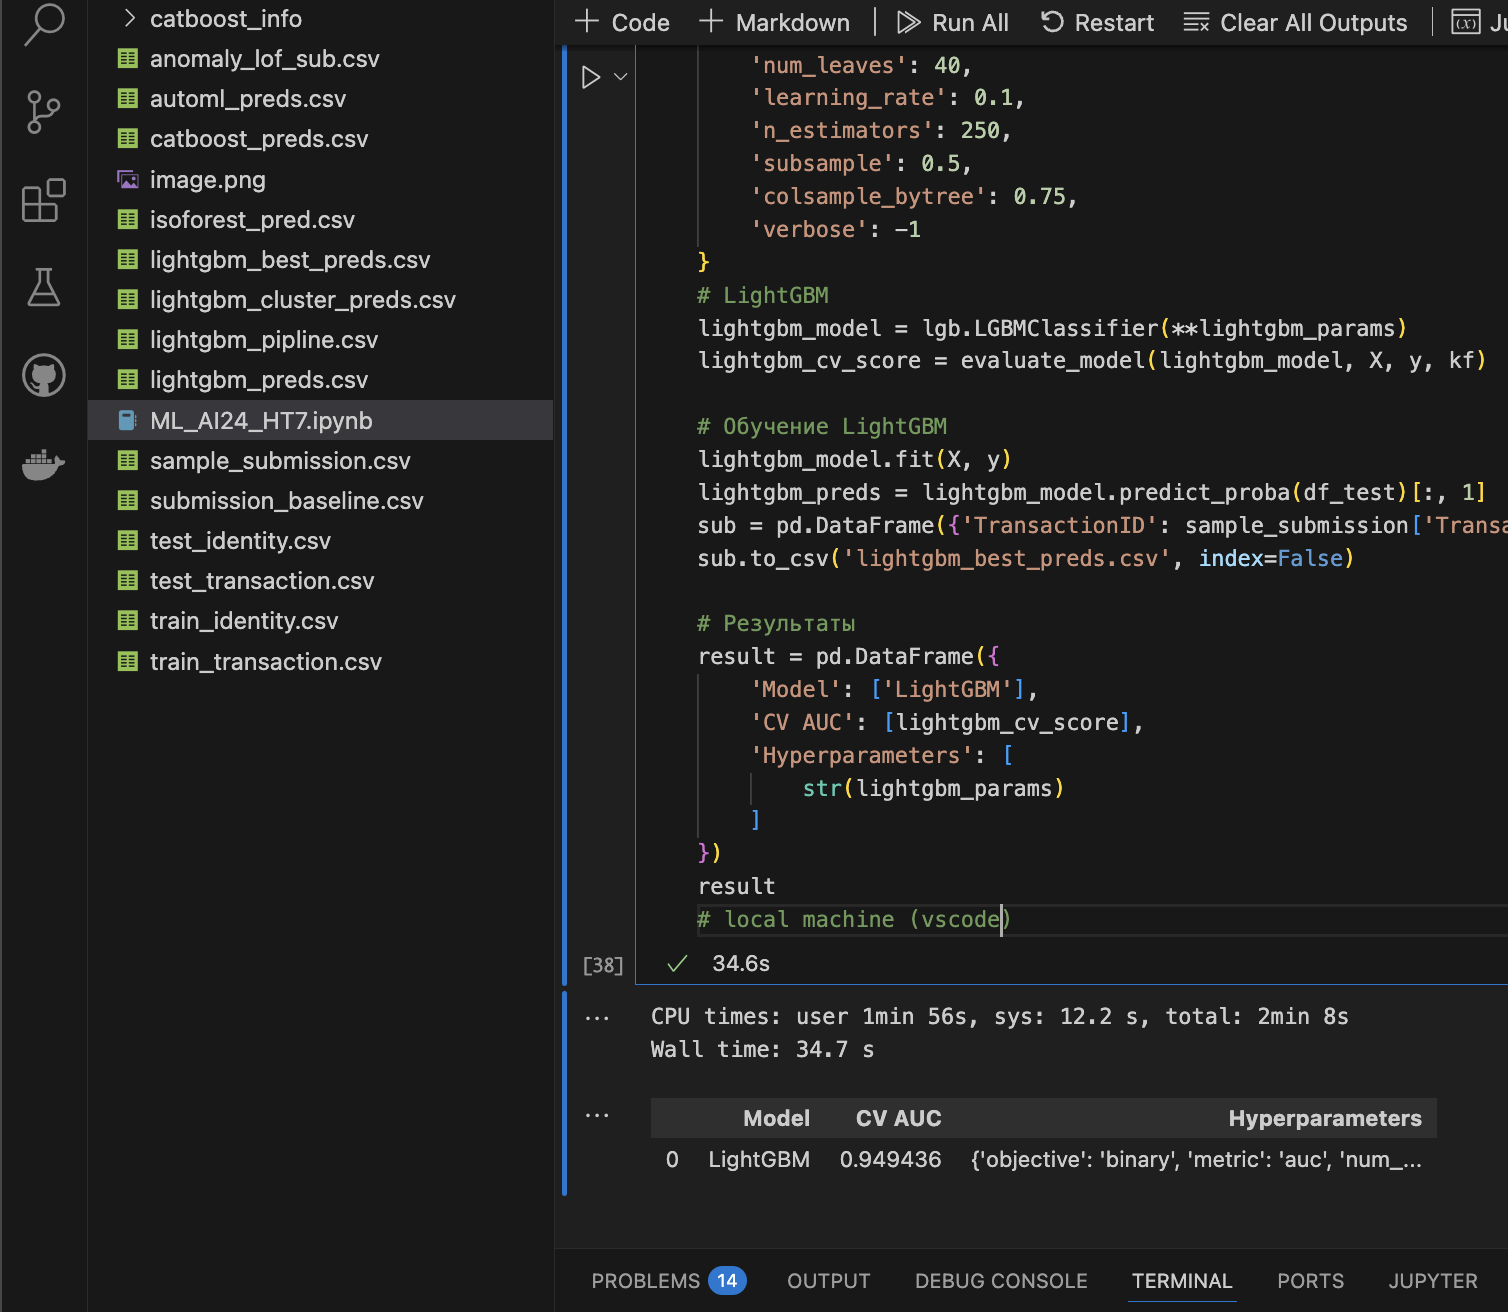

In [2]:
from IPython.display import Image
Image("image2.png", width=500, height=300)

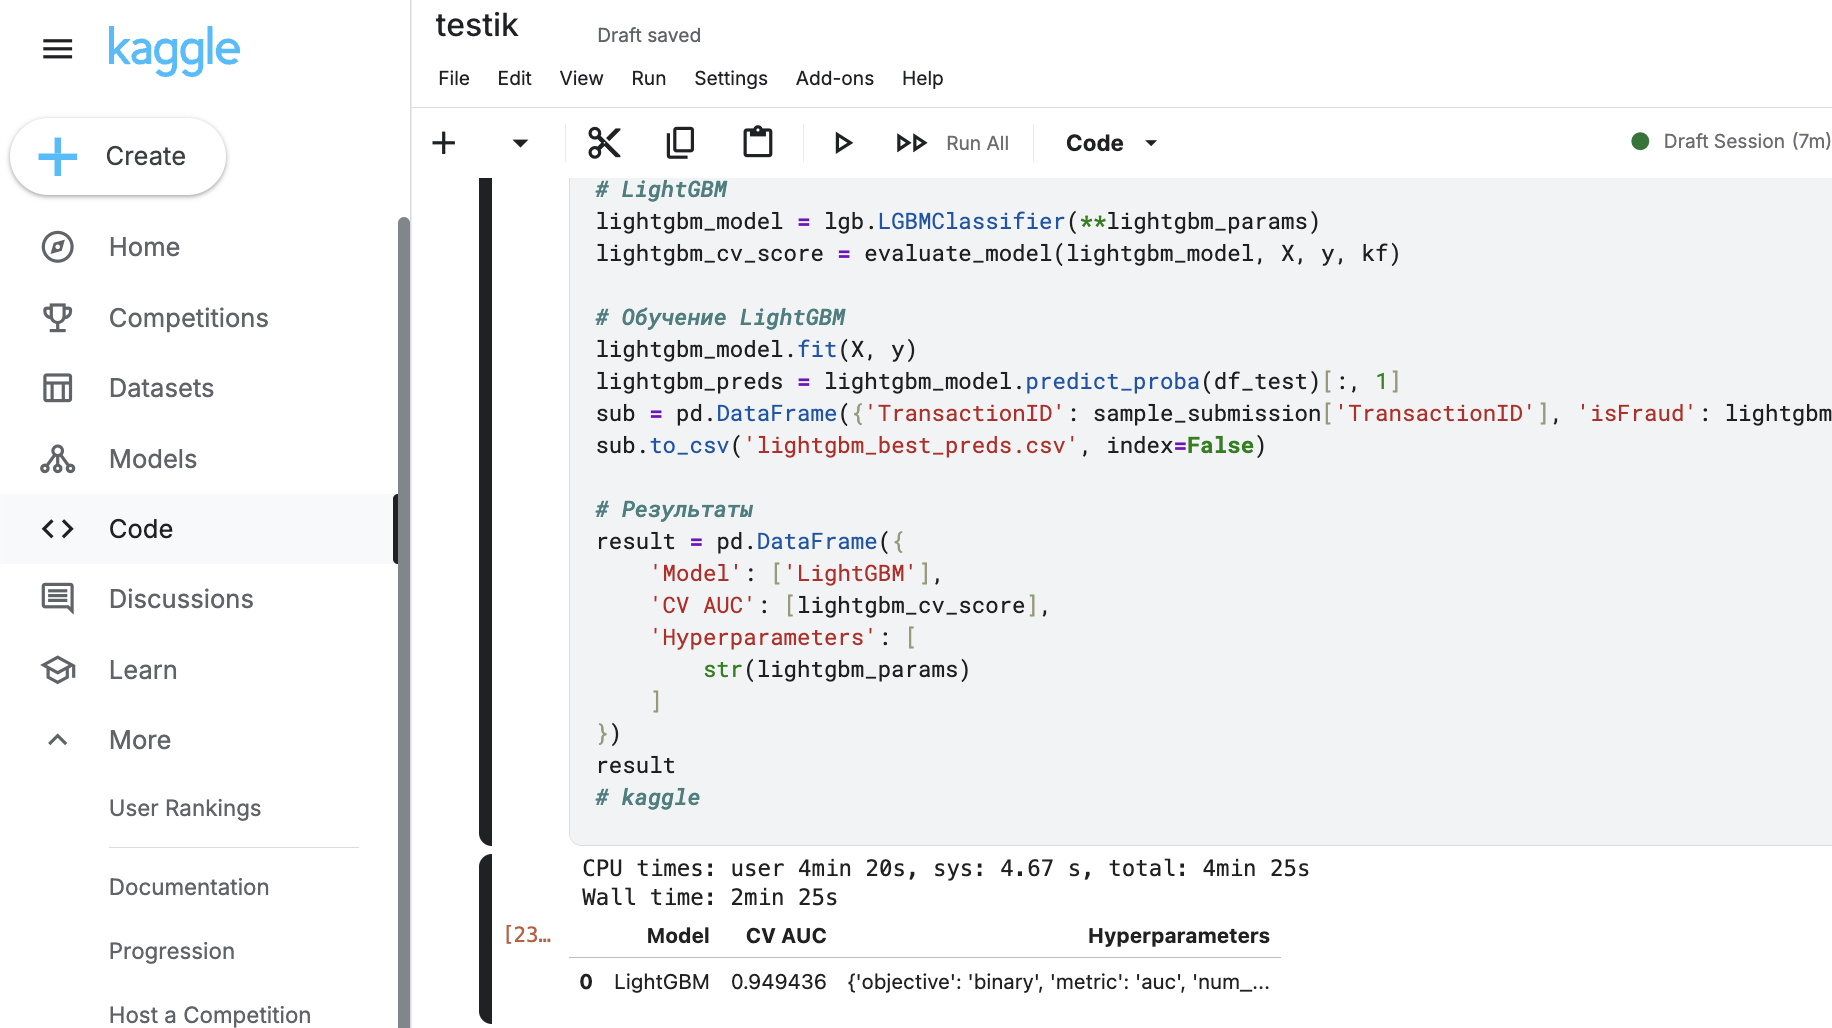

In [3]:
Image("image3.png", width=500, height=300)

Вывод:
1. Коллаб вообще не кушает датасет этот, потому что он большой (не хватает озу)
2. Кеггл намного большие мощности представляет, все отработало хорошо. За 2 минуты.
3. Локально в вскоде все работает супер, но нагружает личный компьютер (это минус), отработало за 30 секунд.

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

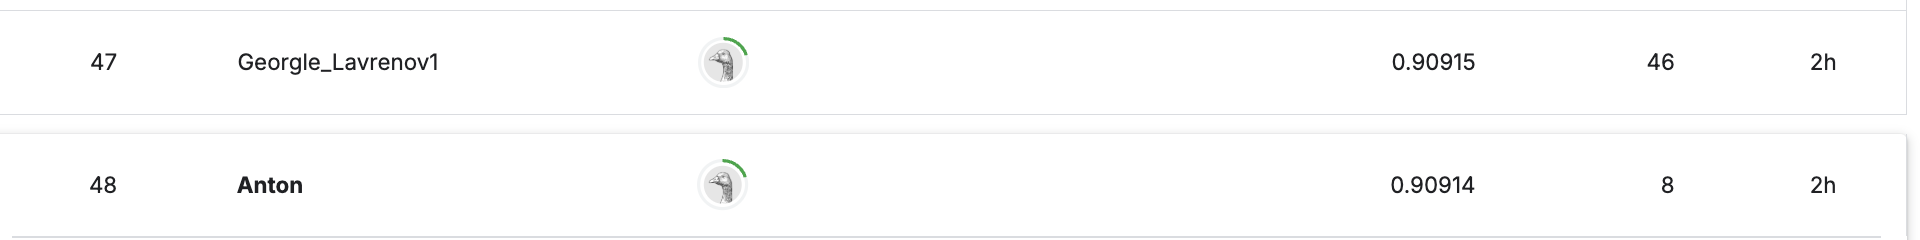

In [5]:
Image("image4.png", width=1000, height=600)

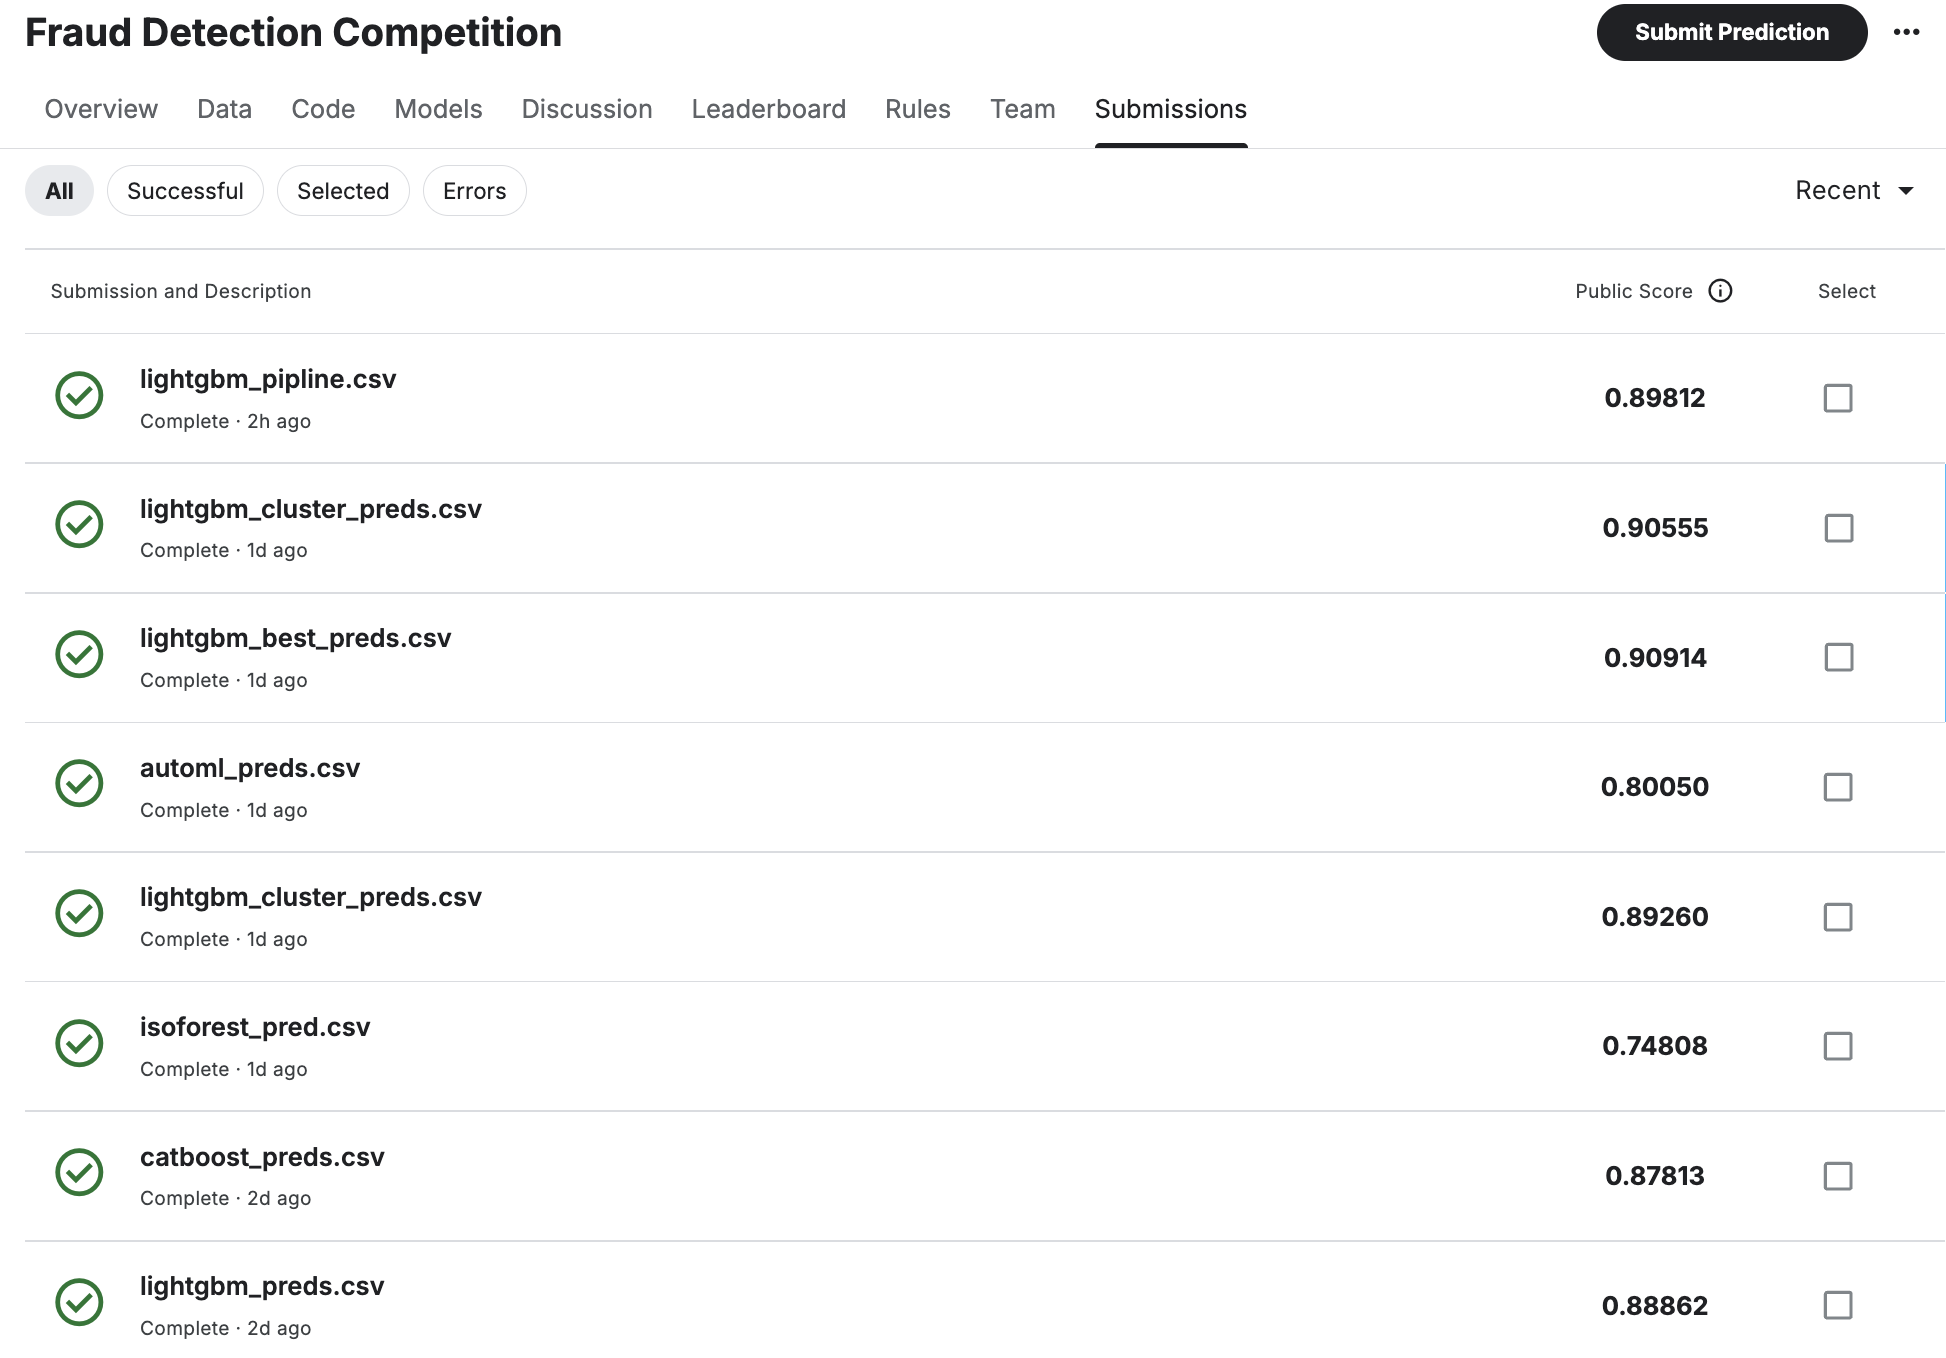

In [6]:
Image("image5.png", width=1000, height=600)